In [1]:
import sqlite3
import pandasql as ps

import pandas as pd
import numpy as np

import openpyxl

from plotnine import *
import plotnine

import scipy

import warnings
warnings.filterwarnings('ignore')

In [2]:
OUT_PATH = 'D:/fvs_calibration/data/interim'

In [3]:
#read in FIA source tables 
DB_PATH = 'D:FIA/FIADB_CA.db'

con = sqlite3.connect(DB_PATH)
# grab fvs_standinit_cond, cond, tree tables, and tree remeasurement table
stands = pd.read_sql_query("select STAND_CN, STAND_ID, INV_YEAR AS INVYR, INV_MONTH, DG_MEASURE from FVS_STANDINIT_COND where VARIANT = 'NC'", con)
cond = pd.read_sql_query("select CN AS STAND_CN, PLT_CN, CONDID, DSTRBCD1, TRTCD1, CONDPROP_UNADJ from COND", con)
trees = pd.read_sql_query("select CN AS TRE_CN, PLT_CN, CONDID, INVYR, TREE, STATUSCD, TPA_UNADJ, SPCD, DIA, HT, VOLCFNET, VOLCFGRS from TREE", con)


Filter FVS_Standinit_cond table to only include stands that:
* Have at at least two measurement years
* Have not experienced disturbance between measurements
* Ten years between measurements - (grow season apr 1 - sept 30)

In [5]:
# some pre-processing
# create STAND_ID2 - scrape stand_id so remeasurement ids match
stands['STAND_ID2'] = stands['STAND_ID'].str[0:3] + stands['STAND_ID'].str[10:]

In [6]:
# identify stands that have had no disturbance or harvest
stands_nodisturb = ps.sqldf("""select s.STAND_CN, s.STAND_ID, s.STAND_ID2, s.INVYR, s.INV_MONTH, s.DG_MEASURE, c.PLT_CN, c.CONDID, c.CONDPROP_UNADJ
                               from stands s 
                               join cond c 
                               on s.STAND_CN = c.STAND_CN 
                               WHERE (c.DSTRBCD1 = NULL OR c.DSTRBCD1 = 0)
                               AND (c.TRTCD1 = NULL OR c.TRTCD1 = 0)
                          """)
stands_nodisturb.shape[0]

1860

In [7]:
# further filter out stands that don't have remeasurement data 
stands = stands_nodisturb.sort_values(by=['STAND_ID2', 'INVYR'])
stands_filtered = stands[stands.duplicated(subset=['STAND_ID2'], keep=False)]
stands_filtered = stands_filtered[['STAND_CN', 'STAND_ID', 'INVYR', 'INV_MONTH', 'DG_MEASURE', 'STAND_ID2', 'PLT_CN', 'CONDID']]
stands_filtered.shape[0]

1206

In [53]:
# filter to only include stands with 10 years between measurements
# or eleven years with no growing season in one year
#first = stands_filtered.drop_duplicates(subset = ['STAND_ID2'], keep = 'first')
second = stands_filtered.drop_duplicates(subset = ['STAND_ID2'], keep = 'last')
second = second.loc[second['DG_MEASURE'] == 10]
second = second[['STAND_ID2']]
stands_filtered2 = stands_filtered.merge(second, how = 'inner', on = 'STAND_ID2')
stands_filtered2.sort_values(by=['STAND_ID2', 'INVYR'])

,STAND_CN,STAND_ID,INVYR,INV_MONTH,DG_MEASURE,STAND_ID2,PLT_CN,CONDID
0,23652219010900,00062001050101015506791,2001.0,6.0,NaN,0000101015506791,23652215010900,1
1,44935357020004,00062011060101015506791,2011.0,8.0,10.0,0000101015506791,48203872010497,1
2,23652672010900,00062001050101015529531,2001.0,5.0,NaN,0000101015529531,23652668010900,1
3,44787408020004,00062011060101015529531,2011.0,5.0,10.0,0000101015529531,48205182010497,1
4,23651224010900,00062001050101015839161,2001.0,6.0,NaN,0000101015839161,23651220010900,1
...,...,...,...,...,...,...,...,...
1023,723023606290487,00062019060904085593011,2019.0,10.0,10.0,0000904085593011,558627136126144,1
1024,446464010497,00062009050904085726821,2009.0,10.0,NaN,0000904085726821,29879848010497,1
1025,723023278290487,00062019060904085726821,2019.0,5.0,10.0,0000904085726821,558627129126144,1
1026,446461010497,00062009050904087670261,2009.0,10.0,NaN,0000904087670261,29879716010497,1


,STAND_CN,STAND_ID,INVYR,INV_MONTH,DG_MEASURE,STAND_ID2,PLT_CN,CONDID
64,44935357020004,00062011060101015506791,2011.0,8.0,10.0,0000101015506791,48203872010497,1
14,44787408020004,00062011060101015529531,2011.0,5.0,10.0,0000101015529531,48205182010497,1
77,44786486020004,00062011060101015839161,2011.0,9.0,10.0,0000101015839161,48203905010497,1
89,44786687020004,00062011060101015910821,2011.0,5.0,10.0,0000101015910821,48205740010497,1
90,44786688020004,00062011060101015910822,2011.0,5.0,10.0,0000101015910822,48205740010497,2
...,...,...,...,...,...,...,...,...
1724,723010607290487,00062019060904053797851,2019.0,5.0,10.0,0000904053797851,558627002126144,1
1725,723010608290487,00062019060904053797852,2019.0,5.0,10.0,0000904053797852,558627002126144,2
1803,723023606290487,00062019060904085593011,2019.0,10.0,10.0,0000904085593011,558627136126144,1
1802,723023278290487,00062019060904085726821,2019.0,5.0,10.0,0000904085726821,558627129126144,1


Tree List
* Filter FVS_Treeinit_cond table to filtered stand list:
* Filter out trees from Time2 that are not present at Time1

In [146]:
# join FVS tree volume estimates
#read in FVS output
DB_PATH = 'D:/fvs_calibration/data/interim/FVSOut.db'
con2 = sqlite3.connect(DB_PATH)
fvs_trees = pd.read_sql_query("select CaseID, StandID, Year, TreeId, TPA, SpeciesFIA, TreeVal, TCuFt, MortPA from FVS_TreeList", con2)
fvs_cases = pd.read_sql_query("select CaseID, StandID, MgmtID from FVS_Cases", con2)

# add scenario description from cases table
fvs_trees = fvs_trees.merge(fvs_cases, on=("StandID", "CaseID"))

fvs_trees['TreeId'] = fvs_trees['TreeId'].astype('int64')
sub_fvs_trees = fvs_trees.loc[((fvs_trees["MgmtID"] == 'Run1') & (fvs_trees["Year"] == 2009)) | ((fvs_trees["MgmtID"] == 'Run2') & (fvs_trees["Year"] == 2019))]
sub_fvs_trees = sub_fvs_trees[['StandID', 'Year', 'TreeId', 'TPA', 'TreeVal', 'TCuFt', 'MgmtID', 'MortPA']]
sub_fvs_trees.shape[0]

990

Read in FIA tree data with volume calculated in NVEL

In [177]:
volume_calc = pd.read_excel('../data/NC_trees_for_NVEL_calc.xlsx' )

In [178]:
# add key values to volume_calc
volume_calc['STAND_CN'] = volume_calc['STAND_CN'].astype(str)
stands_filtered_id = stands_filtered[['STAND_CN', 'STAND_ID', 'STAND_ID2']]
volume_calc = volume_calc.merge(stands_filtered_id, on = 'STAND_CN')

# add cond_prop for later calculations
cond_prop = cond[['STAND_CN', 'CONDPROP_UNADJ']]
volume_calc = volume_calc.merge(cond_prop, on='STAND_CN')

volume_calc = volume_calc[['STAND_CN', 'STAND_ID', 'INVYR', 'TREE', 'STATUSCD', 'TPA_UNADJ', 'CONDPROP_UNADJ', 'VOLUME_CVTS', 'VOLUME_CV4']]
volume_calc.shape[0]

46194

In [179]:
# filter tree calcs to stands in the FVS run
random_stands = random_stands[['STAND_ID']]
volume_calc_sub = volume_calc.merge(random_stands, how='inner', on= 'STAND_ID')

In [180]:
#join with fvs trees 
volume_calc_join = sub_fvs_trees.merge(volume_calc, how="inner", left_on=("StandID", "Year", "TreeId"), right_on=("STAND_ID", "INVYR", "TREE"))

In [181]:
print(sub_fvs_trees.shape[0])
print(volume_calc_join.shape[0])

990
978


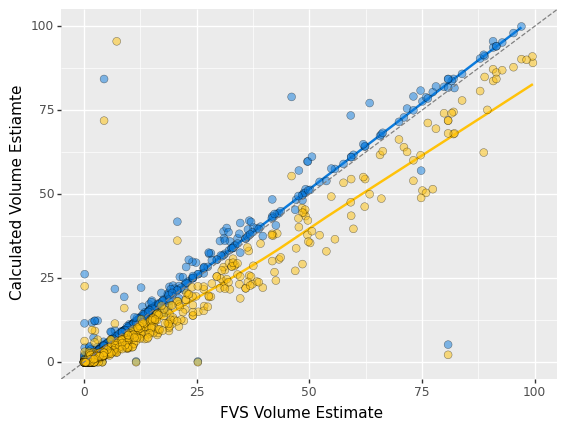

<ggplot: (156639569095)>

In [182]:
(ggplot(volume_calc_join)
    + geom_smooth(mapping = aes(x = 'TCuFt', y ='VOLUME_CV4'), color="#FFC20A", se = False)
    + geom_smooth(mapping = aes(x = 'TCuFt', y ='VOLUME_CVTS'), color="#0C7BDC", se = False)
    + geom_point(mapping = aes(x = 'TCuFt', y ='VOLUME_CVTS'), fill='#0C7BDC', alpha = .5, stroke=.2, size=3)
    + geom_point(mapping = aes(x = 'TCuFt', y ='VOLUME_CV4'), fill='#FFC20A' , alpha = .5, stroke=.2, size=3)
    + geom_abline(slope = 1, intercept = 0, linetype="dashed", color="Grey")
    + scale_x_continuous(limits = (0, 100))
    + scale_y_continuous(limits = (0, 100))
    + xlab("FVS Volume Estimate")
    + ylab("Calculated Volume Estiamte"))

#Blue - Volume CVTS
#Yellow - Volume CV4

The NVEL calculation using CVTS volume type most closely matches FVS volume estimates. However there are discrepancies. 

Lets compare volume estimates at the tree level for each time step when expanded by TPA

In [218]:
# some pre-processing
volume_calc_join['STAND_ID2'] = volume_calc_join['STAND_ID'].str[0:3] + volume_calc_join['STAND_ID'].str[10:]

#create expanded volumes
# NVEL expanded by FIA tpa
volume_calc_join['VOLUME_CVTS_exp'] = volume_calc_join['VOLUME_CVTS'] * volume_calc_join['TPA_UNADJ']
# NVEL expanded by FVS tpa
volume_calc_join['VOLUME_CVTS_tpa'] = volume_calc_join['VOLUME_CVTS'] * volume_calc_join['TPA']
# FIA expanded by manually created FVS tpa
volume_calc_join['VOLUME_CVTS_tpa2'] = volume_calc_join['VOLUME_CVTS'] * (volume_calc_join['TPA_UNADJ']/volume_calc_join['CONDPROP_UNADJ'])
# FVS expanded by FVS tpa
volume_calc_join['TCuFt_exp'] = volume_calc_join['TCuFt'] * volume_calc_join['TPA']

In [219]:
# check to see if FVS tpa and manually created FVS tpa are identical 
(volume_calc_join['VOLUME_CVTS_tpa'] - volume_calc_join['VOLUME_CVTS_tpa2']).describe()

count    9.760000e+02
mean     1.187410e+00
std      1.658693e+02
min     -8.079811e+02
25%     -1.137216e-06
50%     -1.330439e-07
75%      1.949494e-06
max      4.647090e+03
dtype: float64

Good, we can recreate FVS TPA from the cond and tree tables.  Now lets expanded volumes at the tree level.

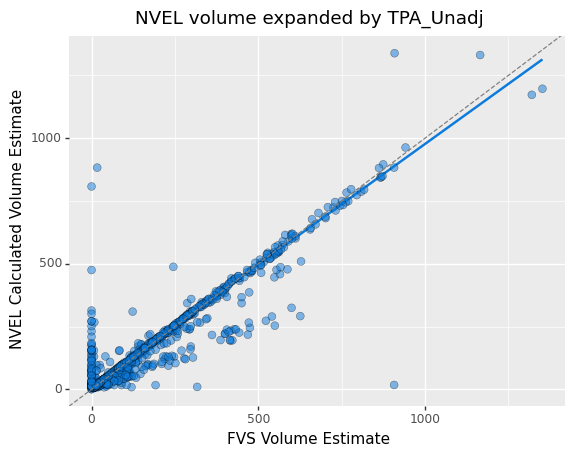

<ggplot: (156637710796)>

In [221]:
(ggplot(volume_calc_join, mapping = aes(x = 'TCuFt_exp', y ='VOLUME_CVTS_exp'))
    + geom_smooth(color="#0C7BDC", se = True)
    + geom_point(fill='#0C7BDC', alpha = .5, stroke=.2, size=3)
    + geom_abline(slope = 1, intercept = 0, linetype="dashed", color="Grey")
    #+ scale_x_continuous(limits = (0, 100))
    #+ scale_y_continuous(limits = (0, 100))
    + labs(x ="FVS Volume Estimate",
          y = "NVEL Calculated Volume Estimate", 
          title = "NVEL volume expanded by TPA_Unadj"))


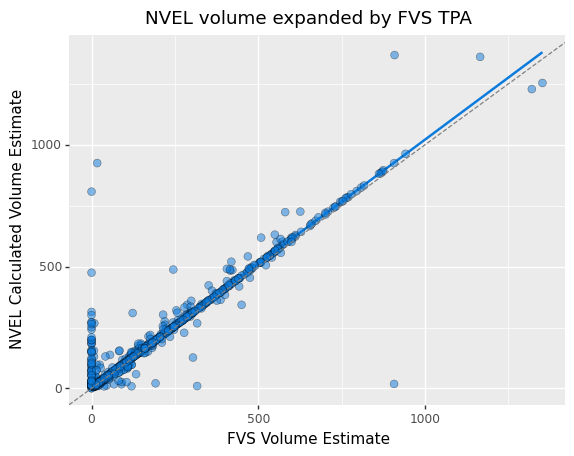

<ggplot: (156633121624)>

In [222]:
(ggplot(volume_calc_join)
    + geom_smooth(mapping = aes(x = 'TCuFt_exp', y ='VOLUME_CVTS_tpa2'), color="#0C7BDC", se = False)
    + geom_point(mapping = aes(x = 'TCuFt_exp', y ='VOLUME_CVTS_tpa2'), fill='#0C7BDC', alpha = .5, stroke=.2, size=3)
    + geom_abline(slope = 1, intercept = 0, linetype="dashed", color="Grey")
    #+ scale_x_continuous(limits = (0, 100))
    #+ scale_y_continuous(limits = (0, 2000))
    + labs(x ="FVS Volume Estimate",
          y = "NVEL Calculated Volume Estimate", 
          title = "NVEL volume expanded by FVS TPA"))

Let's compare total volumes at the stand level

In [286]:
sub_fvs_trees['TCuFt_exp'] = sub_fvs_trees['TCuFt'] * sub_fvs_trees['TPA']
fvs_trees_agg = sub_fvs_trees.groupby(['StandID', 'Year', 'TreeVal'], as_index=False).agg({'TCuFt_exp': 'sum'}).rename(columns={'TCuFt_exp': 'tcuft'})

In [287]:
volume_calc_sub['VOLUME_CVTS_exp'] = volume_calc_sub['VOLUME_CVTS'] * volume_calc_sub['TPA_UNADJ']
volume_calc_sub['VOLUME_CVTS_tpa2'] = volume_calc_sub['VOLUME_CVTS'] * (volume_calc_sub['TPA_UNADJ']/volume_calc_sub['CONDPROP_UNADJ'])
nvel_trees_agg = volume_calc_sub.groupby(['STAND_ID', 'INVYR', 'STATUSCD'], as_index=False).agg({'VOLUME_CVTS_exp': 'sum', 'VOLUME_CVTS_tpa2': 'sum'}).rename(columns={'VOLUME_CVTS_exp': 'cvts', 'VOLUME_CVTS_tpa2': 'cvts_tpa2'})
#get common on the tree value/STATUSCD values
nvel_trees_agg.loc[(nvel_trees_agg['STATUSCD'] == 6), 'STATUSCD'] = 7
nvel_trees_agg.loc[(nvel_trees_agg['STATUSCD'] == 8), 'STATUSCD'] = 9


In [288]:
# join tables
trees_agg = fvs_trees_agg.merge(nvel_trees_agg, how='inner', left_on = ('StandID', 'Year', 'TreeVal'), right_on = ('STAND_ID', 'INVYR', 'STATUSCD'))
trees_agg = trees_agg[['StandID', 'Year', 'TreeVal', 'STATUSCD', 'tcuft', 'cvts', 'cvts_tpa2']]

In [289]:
# compare that to the summary table from FVS

# grab summary table
fvs_summary = pd.read_sql_query("select CaseID, StandID, Year, Tpa, TCuFt, Mort, Acc from FVS_Summary2", con2)

# add scenario description from cases table
fvs_summary = fvs_summary.merge(fvs_cases, on=("StandID", "CaseID"))
sub_fvs_summary = fvs_summary.loc[((fvs_summary["MgmtID"] == 'Run1') & (fvs_summary["Year"] == 2009)) | ((fvs_summary["MgmtID"] == 'Run2') & (fvs_summary["Year"] == 2019))]

sub_fvs_summ = sub_fvs_summary[['StandID', 'Year', 'TCuFt']]
sub_fvs_summary['STAND_ID2'] = sub_fvs_summary['StandID'].str[0:3] + sub_fvs_summary['StandID'].str[10:]
sub_fvs_mort = sub_fvs_summary[['STAND_ID2', 'Year', 'Mort']]

# # join with trees_agg
all_agg = sub_fvs_summ.merge(trees_agg, on=('StandID', 'Year'))
all_agg.rename(columns={"TCuFt": "summary"}, inplace = True)
all_agg['STAND_ID2'] = all_agg['StandID'].str[0:3] + all_agg['StandID'].str[10:]

all_agg.head(1)

,StandID,Year,summary,TreeVal,STATUSCD,tcuft,cvts,cvts_tpa2,STAND_ID2
0,00062009050902093713221,2009,10297.44043,1,1,10297.44067,10520.571589,10756.372793,0000902093713221


In [290]:
all_agg_acc = all_agg[all_agg['STATUSCD'] == 1]
all_agg_acc = pd.melt(all_agg_acc, id_vars=['STAND_ID2', 'Year', 'STATUSCD'])
all_agg_acc['value'] = all_agg_acc['value'].astype('float64')
all_agg_acc = all_agg_acc[all_agg_acc['variable'].isin(['summary', 'tcuft', 'cvts', 'cvts_tpa2'])]


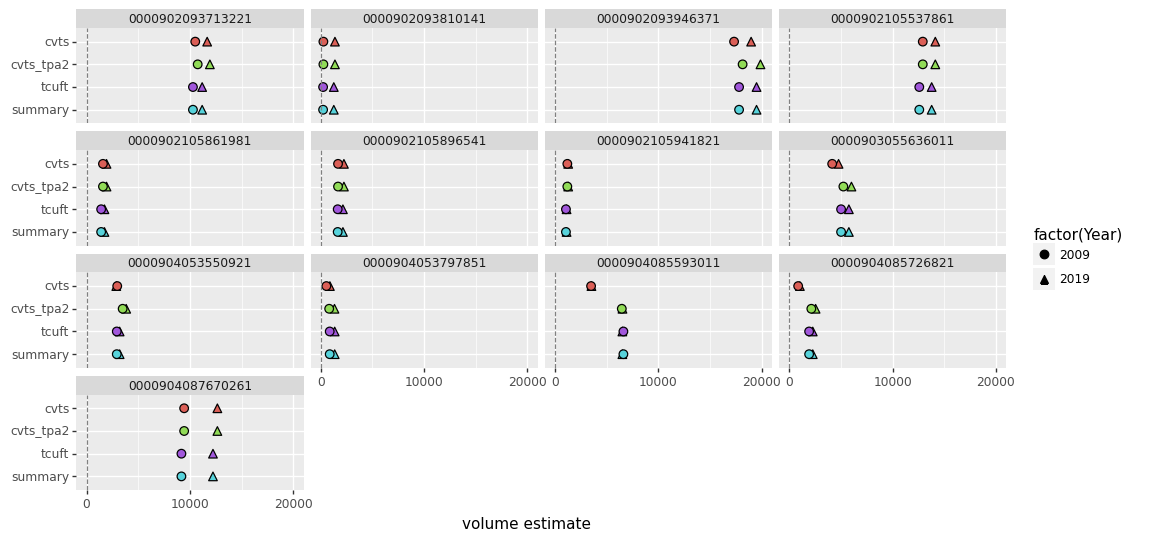

<ggplot: (156654941067)>

In [292]:
(ggplot(all_agg_acc, mapping = aes(x = 'value', y ='variable', fill='variable', shape='factor(Year)'))
    + geom_point(size = 3)
    + facet_wrap('STAND_ID2')
    + geom_vline(xintercept=0, linetype="dashed", color="Grey")
    + scale_fill_discrete(guide=False)
    + scale_y_discrete(limits=("summary", "tcuft","cvts_tpa2", "cvts"))
    + scale_x_continuous(limits=(0, 20000), breaks=(0, 10000, 20000))
    + xlab("volume estimate")
    + ylab("")
    + theme(figure_size=(12,6))
) 

Accreation estimates descriptions:
* **summary**: (FVS_Summary TCuFt value - Total TCuFt volume by stand)
* **tcuft**: Summed tree tcuft values as calcuated by FVS 
* **cvts**: Summed tree tcuft values as calcuated by NVEL, expanded using tpa_unadj
* **cvts_tpa2**: Summed tree tcuft values as calcuated by NVEL expanded using manually calculated TPA values from FIA (tpa_unadj/condprop)

In [277]:
all_agg_acc2= all_agg[all_agg['STATUSCD'] == 1]

fia = all_agg_acc2['summary'].to_numpy()
nvel = all_agg_acc2['cvts'].to_numpy()
nvel2  = all_agg_acc2['cvts_tpa2'].to_numpy()


def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

print(rsquared(fia, nvel))
print(rsquared(fia, nvel2))
print(rsquared(nvel, nvel2))

0.973843046705702
0.9988946624905809
0.9779184852778118


Volume of FIA trees with NVEL calculated volume is most similar to FVS TCuFt summary.  To match Accretion value in Summary table, we will need to add mortality to FIA sum. (Or subtract mortality from FVS ACC value), as well as divide by length of cycle. 

Lets move on to Mortality. First we will compare the sum of dead trees in FVS and FIA. Since FVS converts TPA values of mortality trees to 0 - we will need to use the FIA calculated TPA value. 

In [282]:
# FVS dead trees
# select  dead trees
dead = sub_fvs_trees['TreeVal'].isin([7])
dead_fvs = sub_fvs_trees[dead]

# get TPA values from FIA
vol_id = volume_calc_sub[['STAND_ID', 'INVYR', 'TREE', 'TPA_UNADJ']]
dead_fvs = dead_fvs.merge(vol_id, how='inner', left_on = ['StandID', 'Year', 'TreeId'], right_on = ['STAND_ID', 'INVYR', 'TREE'])

# expand volume 
dead_fvs['TCuFt_exp'] = dead_fvs['TCuFt'] * dead_fvs['TPA_UNADJ']
# sum volume by stand
dead_fvs['STAND_ID2'] = dead_fvs['StandID'].str[0:3] + dead_fvs['StandID'].str[10:]
dead_fvs_agg = dead_fvs.groupby(['STAND_ID2', 'Year'], as_index=False).agg({'TCuFt_exp': 'sum'}).rename(columns={'TCuFt_exp': 'tcuft_tpa2'})

In [283]:
all_agg_mort2 = all_agg[all_agg['STATUSCD'] == 7]

all_agg_mort2 = all_agg_mort2.merge(sub_fvs_mort, on = ('STAND_ID2', 'Year'))
# multiple mort by legnth of cycle
all_agg_mort2['Mort'] = all_agg_mort2['Mort']*10
all_agg_mort2 = all_agg_mort2.merge(dead_fvs_agg, on = ('STAND_ID2', 'Year'))
all_agg_mort2 = all_agg_mort2.drop_duplicates()
all_agg_mort = pd.melt(all_agg_mort2, id_vars=['STAND_ID2', 'Year', 'STATUSCD'])
all_agg_mort['value'] = all_agg_mort['value'].astype('float64')
all_agg_mort = all_agg_mort[all_agg_mort['variable'].isin(['cvts', 'cvts_tpa2', 'Mort', 'tcuft_tpa2'])]


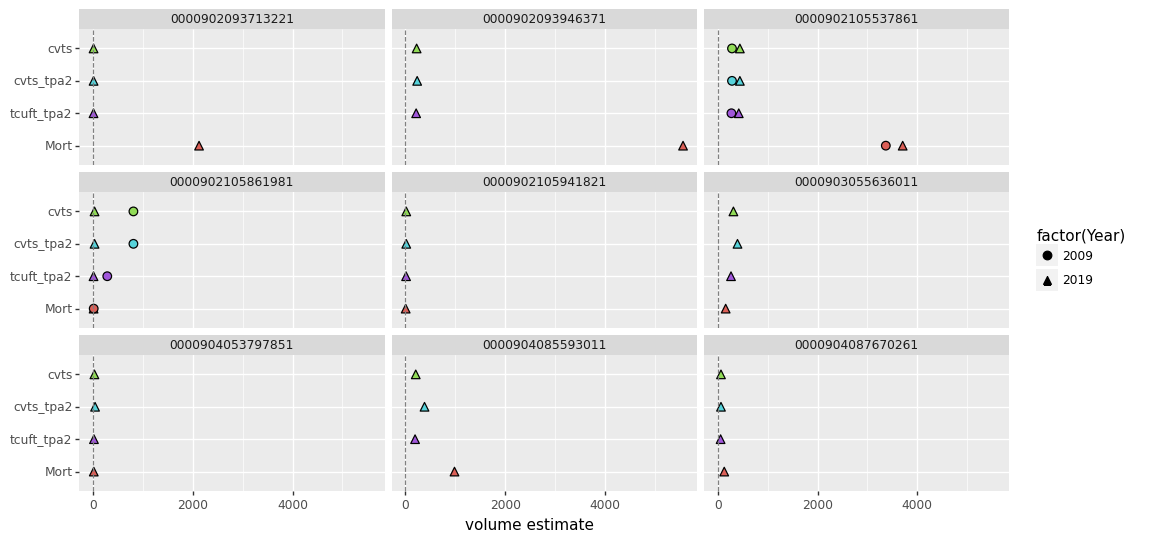

<ggplot: (156655441680)>

In [284]:
(ggplot(all_agg_mort, mapping = aes(x = 'value', y ='variable', fill='variable', shape='factor(Year)'))
    + geom_point(size = 3)
    + facet_wrap('STAND_ID2')
    + geom_vline(xintercept=0, linetype="dashed", color="Grey")
    + scale_fill_discrete(guide=False)
    + scale_y_discrete(limits=("Mort","tcuft_tpa2", "cvts_tpa2", "cvts"))
    #+ scale_x_continuous(limits=(0, 1100), breaks=(0, 500, 1000))
    + xlab("volume estimate")
    + ylab("")
    + theme(figure_size=(12,6))
) 

Mortality estimates descriptions:
* **Mort**: (FVS_Summary Mortality value - estimated from simulation (not actual mortality)) * cycle length(10)
* **tcuft_tpa2**: Summed tree tcuft values as calcuated by FVS, for dead trees, expanded using manually calculated TPA values from FIA (tpa_unadj/condprop)
* **cvts**: Summed tree tcuft values as calcuated by NVEL, for dead trees, expanded using tpa_unadj
* **cvts_tpa2**: Summed tree tcuft values as calcuated by NVEL, for dead trees, expanded using manually calculated TPA values from FIA (tpa_unadj/condprop)

In [285]:
fvs = all_agg_mort2['Mort'].to_numpy()
nvel = all_agg_mort2['cvts'].to_numpy()
nvel2  = all_agg_mort2['cvts_tpa2'].to_numpy()
fvs2  = all_agg_mort2['tcuft_tpa2'].to_numpy()


def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

print(rsquared(fvs2, nvel))
print(rsquared(fvs2, nvel2))
print(rsquared(fvs, fvs2))

0.6418403076069944
0.6631224668394711
0.23497576018429917


In [117]:
con.close()
con2.close()

FVS calcuations for Mort and Acc values
* **Acc**: ((stand.tcuft(T2) - stand.tcuft(T1))/cycle length) + Mort
* **Mort**: sum(tree.morttpa * tree.tcuft)/cycle length